In [36]:
!pip install yfinance
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-23 14:38:18--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-23 14:38:19--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-12-23 14:38:19--  http://

In [37]:
import numpy as np  
import pandas as pd  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM, GRU  
from tensorflow.keras.layers import Dropout  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import yfinance as yf
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
finbert_scores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock_Price_Prediction/finbert_scores_all.csv', index_col='Date')
finbert_scores.index = pd.to_datetime(finbert_scores.index)
nlp_method_scores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock_Price_Prediction/nlp_method_scores.csv', index_col='Date')
nlp_method_scores.index = pd.to_datetime(nlp_method_scores.index)
scores_all = pd.merge(left=finbert_scores, right=nlp_method_scores, on='Date')

In [40]:
dataset =  yf.download('AMZN', start = '2013-09-05', end = '2022-11-25')
USD_index = yf.download('DX-Y.NYB', start = '2013-09-05', end = '2022-11-25')
gold = yf.download('GLD', start = '2013-09-05', end = '2022-11-25')
dataset['gold'] = gold['Adj Close']
dataset['USD_index'] = USD_index['Adj Close']
fed_fund_rate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock_Price_Prediction/fed-funds-rate-historical-chart.csv', index_col = 0)
fed_fund_rate.index = pd.to_datetime(fed_fund_rate.index)
dataset['fed_fund_rate'] = fed_fund_rate

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [41]:
dataset = pd.merge(left=dataset, right=scores_all, on='Date')

In [42]:
dataset

,Open,High,Low,Close,Adj Close,Volume,gold,USD_index,fed_fund_rate,Sentiment_Mean,Sentiment_Min,Sentiment_Max,Sentiment_Median,TextBlob,SnowNLP,Spacy,Vader
Date,,,,,,,,,,,,,,,,,
2013-09-05,14.681500,14.850000,14.635500,14.705000,14.705000,36332000,132.199997,82.629997,0.08,0.913513,0.913513,0.913513,0.913513,0.000000,0.447678,0.000000,0.000000
2013-09-06,14.766500,14.944000,14.540000,14.793000,14.793000,45840000,134.149994,82.150002,0.08,0.559853,0.559853,0.559853,0.559853,0.193182,0.371652,0.193182,0.381800
2013-09-09,14.861000,14.998000,14.830000,14.985500,14.985500,32872000,133.910004,81.790001,0.08,0.747177,0.454362,0.952468,0.903192,0.070000,0.418492,0.070000,-0.017900
2013-09-12,14.969500,15.100000,14.883000,14.943000,14.943000,32124000,127.669998,81.489998,0.08,0.777028,0.628260,0.909878,0.784986,0.298214,0.322998,0.298214,0.015475
2013-09-13,15.007000,15.011000,14.810000,14.896000,14.896000,27012000,127.820000,81.449997,0.08,0.894998,0.894998,0.894998,0.894998,-0.200000,0.371652,-0.200000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,95.370003,96.970001,94.029999,94.849998,94.849998,82617900,163.919998,106.690002,3.83,0.871481,0.660187,0.962310,0.871300,0.010058,0.324174,0.010058,0.129849
2022-11-18,95.949997,95.989998,92.480003,94.139999,94.139999,72428200,162.789993,106.930000,3.83,0.781557,0.520047,0.926462,0.798201,-0.058958,0.326427,-0.058958,0.018515
2022-11-21,93.970001,95.019997,90.589996,92.459999,92.459999,84330300,161.880005,107.839996,3.83,0.796527,0.672660,0.885604,0.813923,0.105492,0.362368,0.105492,0.066437


In [43]:
dataset['k'], dataset['d'] = talib.STOCH(dataset['High'], dataset['Low'], dataset['Close'], fastk_period=9, slowk_period=3, slowk_matype=1, slowd_period=3, slowd_matype=1)
dataset['ema_fast'] = dataset['Adj Close'].ewm(span=12).mean()
dataset['ema_slow'] = dataset['Adj Close'].ewm(span=26).mean()
dataset['macd'] = dataset.ema_fast - dataset.ema_slow
# dataset['signal'] = dataset.macd.ewm(span=9).mean()
# dataset['histograma'] = dataset.macd - dataset.signal
dataset['MOM'] = talib.MOM(dataset['Adj Close'], timeperiod = 20)
dataset['OBV'] = talib.OBV(dataset['Adj Close'], dataset['Volume'])

In [44]:
print(dataset.shape)
print(dataset.head())

(2300, 24)
               Open    High      Low    Close  Adj Close    Volume  \
Date                                                                 
2013-09-05  14.6815  14.850  14.6355  14.7050    14.7050  36332000   
2013-09-06  14.7665  14.944  14.5400  14.7930    14.7930  45840000   
2013-09-09  14.8610  14.998  14.8300  14.9855    14.9855  32872000   
2013-09-12  14.9695  15.100  14.8830  14.9430    14.9430  32124000   
2013-09-13  15.0070  15.011  14.8100  14.8960    14.8960  27012000   

                  gold  USD_index  fed_fund_rate  Sentiment_Mean  ...  \
Date                                                              ...   
2013-09-05  132.199997  82.629997           0.08        0.913513  ...   
2013-09-06  134.149994  82.150002           0.08        0.559853  ...   
2013-09-09  133.910004  81.790001           0.08        0.747177  ...   
2013-09-12  127.669998  81.489998           0.08        0.777028  ...   
2013-09-13  127.820000  81.449997           0.08        0.89

In [45]:
# dataset.columns

In [46]:
data = dataset[['Open',
                'High',
                'Low',
                'Close',
                'Adj Close',
                'Volume',
                'k',
                'd',
                # 'Sentiment_Mean',
                # 'Sentiment_Min',
                # 'Sentiment_Max',
                # 'Sentiment_Median',
                # 'TextBlob',
                # 'SnowNLP',
                # 'Spacy',
                # 'Vader',
                # 'ema_fast',
                # 'ema_slow',
                'macd',
                'MOM',
                'OBV',
                'USD_index',
                'fed_fund_rate',
                'gold']]

In [47]:
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,k,d,macd,MOM,OBV,USD_index,fed_fund_rate,gold
Date,,,,,,,,,,,,,,
2013-10-15,15.493500,15.5395,15.263000,15.320000,15.320000,45222000,39.772666,39.766236,0.010229,0.615000,104470000.0,80.480003,0.10,123.730003
2013-10-16,15.419000,15.5400,15.277500,15.524500,15.524500,43414000,46.362489,43.064362,0.014771,0.731500,147884000.0,80.500000,0.11,123.540001
2013-10-17,15.353500,15.5500,15.262000,15.538500,15.538500,52968000,50.187299,46.625831,0.019070,0.552999,200852000.0,79.650002,0.10,127.419998
2013-10-18,15.968000,16.5945,15.837500,16.446501,16.446501,119396000,70.911710,58.768771,0.084606,1.503501,320248000.0,79.639999,0.10,126.849998
2013-10-21,16.494499,16.5000,16.190001,16.322001,16.322001,50446000,77.755965,68.262368,0.125921,1.426001,269802000.0,79.680000,0.09,126.980003


In [48]:
sc = MinMaxScaler()
sc_Y = MinMaxScaler()
scaled_data = sc.fit_transform(data)
sc_Y.fit(data['Adj Close'].values.reshape(-1,1))

MinMaxScaler()

In [49]:
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_data.head()

,Open,High,Low,Close,Adj Close,Volume,k,d,macd,MOM,OBV,USD_index,fed_fund_rate,gold
Date,,,,,,,,,,,,,,
2013-10-15,0.007362,0.005849,0.006230,0.005647,0.005647,0.060057,0.378235,0.377118,0.604967,0.608470,0.040122,0.038319,0.015831,0.248742
2013-10-16,0.006931,0.005852,0.006314,0.006834,0.006834,0.056122,0.448362,0.413399,0.605188,0.609910,0.043689,0.038890,0.018470,0.246707
2013-10-17,0.006553,0.005909,0.006224,0.006915,0.006915,0.076915,0.489065,0.452577,0.605397,0.607703,0.048039,0.014584,0.015831,0.288254
2013-10-18,0.010105,0.011908,0.009596,0.012188,0.012188,0.221482,0.709607,0.586156,0.608583,0.619452,0.057847,0.014298,0.015831,0.282150
2013-10-21,0.013149,0.011365,0.011662,0.011465,0.011465,0.071426,0.782442,0.690591,0.610592,0.618494,0.053703,0.015442,0.013193,0.283542


In [50]:
N_past = 20
M_future = 5

In [51]:
test_percentage = 0.15
test_split = int(len(scaled_data)*(1 - test_percentage))

In [52]:
train = scaled_data[:test_split]
test = scaled_data[test_split-N_past:]
print(train.shape)
print(test.shape)

(1927, 14)
(361, 14)


In [53]:
def split_dataset_X_Y(data, past, future, jump=1):
  X,Y = [],[]
  for i in range(0, len(data) - past - future + 1, jump):
    X.append(data[i : (i+past)].values)
    Y.append(data['Adj Close'][(i + past) : (i + past + future)])
  return np.array(X), np.array(Y)

In [54]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future)

In [55]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(1522, 20, 14)
(1522, 5)
(381, 20, 14)
(381, 5)
(337, 20, 14)
(337, 5)


In [57]:
EPOCHS = 100

In [58]:
model = Sequential()
model.add(GRU(128, input_shape=(N_past, data.shape[1]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.2))
model.add(Dense(M_future))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 20, 128)           55296     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 92,869
Trainable params: 92,869
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_validation, y_validation), shuffle=True, batch_size=8, verbose=2)

Epoch 1/100
191/191 - 5s - loss: 0.0113 - val_loss: 0.0105 - 5s/epoch - 24ms/step
Epoch 2/100
191/191 - 1s - loss: 0.0044 - val_loss: 0.0042 - 1s/epoch - 6ms/step
Epoch 3/100
191/191 - 1s - loss: 0.0037 - val_loss: 0.0085 - 1s/epoch - 6ms/step
Epoch 4/100
191/191 - 1s - loss: 0.0033 - val_loss: 6.9128e-04 - 1s/epoch - 6ms/step
Epoch 5/100
191/191 - 1s - loss: 0.0027 - val_loss: 7.2183e-04 - 1s/epoch - 6ms/step
Epoch 6/100
191/191 - 1s - loss: 0.0023 - val_loss: 0.0022 - 1s/epoch - 6ms/step
Epoch 7/100
191/191 - 1s - loss: 0.0021 - val_loss: 4.0545e-04 - 1s/epoch - 6ms/step
Epoch 8/100
191/191 - 1s - loss: 0.0020 - val_loss: 0.0058 - 1s/epoch - 6ms/step
Epoch 9/100
191/191 - 1s - loss: 0.0019 - val_loss: 0.0066 - 1s/epoch - 6ms/step
Epoch 10/100
191/191 - 1s - loss: 0.0016 - val_loss: 0.0011 - 1s/epoch - 6ms/step
Epoch 11/100
191/191 - 1s - loss: 0.0016 - val_loss: 2.6351e-04 - 1s/epoch - 6ms/step
Epoch 12/100
191/191 - 1s - loss: 0.0015 - val_loss: 3.0352e-04 - 1s/epoch - 6ms/step
Epoc

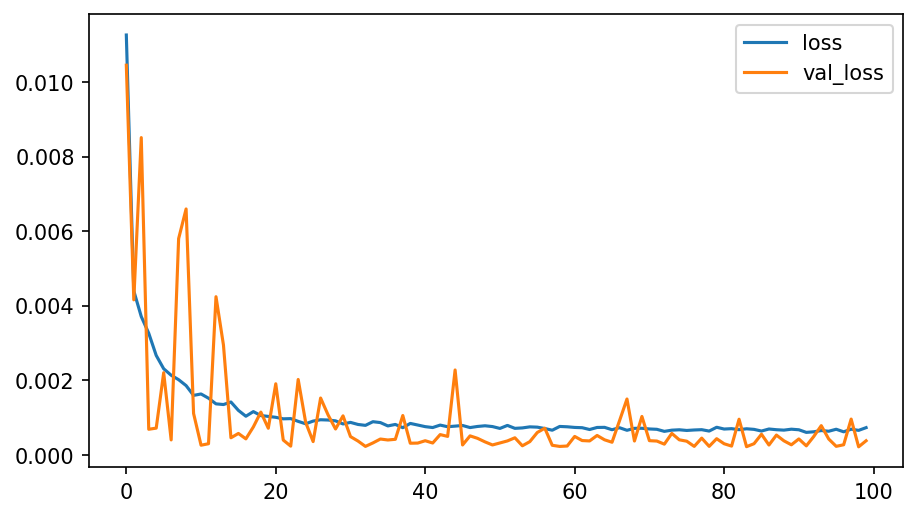

In [60]:
plt.figure(figsize = (7,4), dpi=150)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [61]:
y_pred = model.predict(X_test)

11/11 [==============================] - 1s 3ms/step


In [62]:
df = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,0].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,0].reshape(-1,1)).flatten()},
                   test[N_past:N_past+len(y_test)].index)

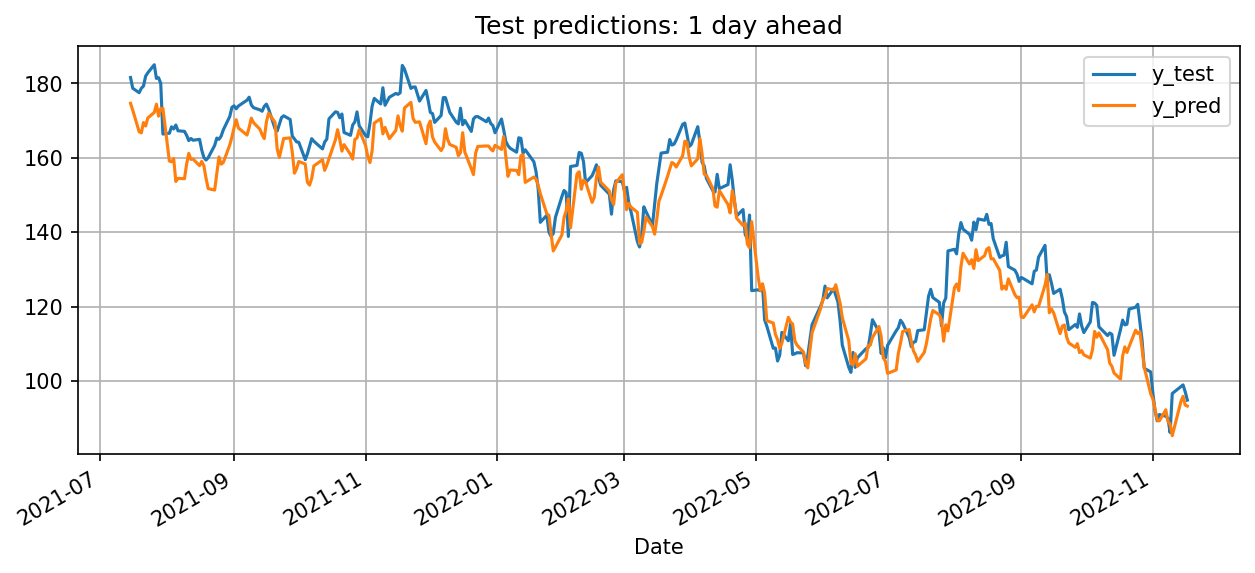

In [63]:
fig = plt.figure(figsize=(10,4), dpi=150)
df['y_test'].plot()
df['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: 1 day ahead')
plt.grid(True)
plt.show()

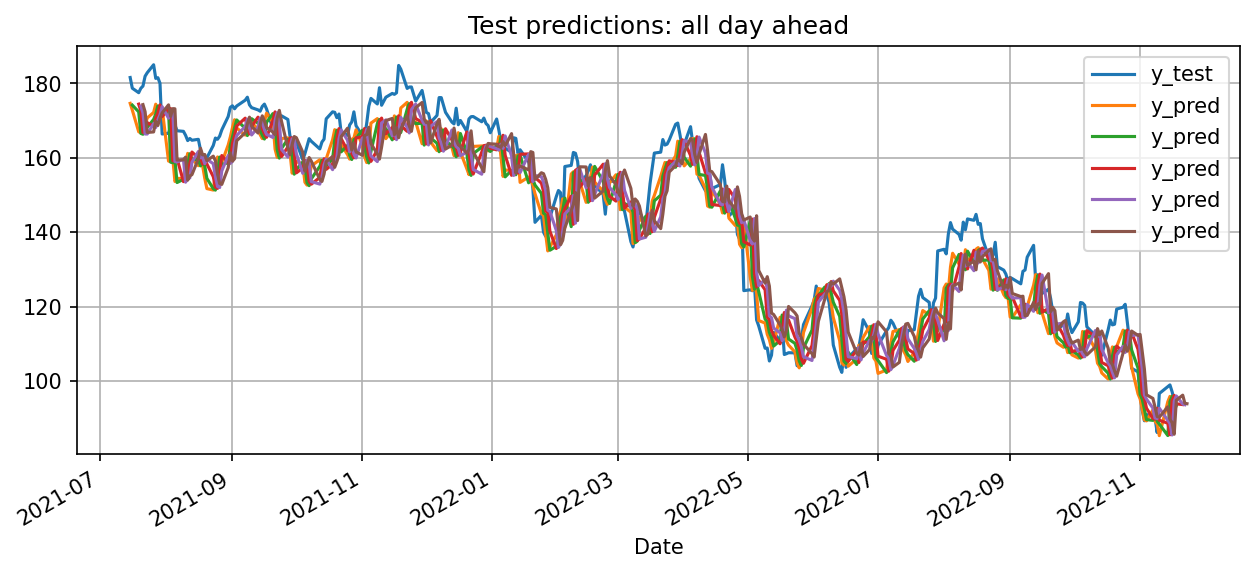

In [64]:
df2 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,1].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,1].reshape(-1,1)).flatten()},
                   test[N_past+1:N_past+len(y_test)+1].index)
df3 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,2].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,2].reshape(-1,1)).flatten()},
                   test[N_past+2:N_past+len(y_test)+2].index)
df4 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,3].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,3].reshape(-1,1)).flatten()},
                   test[N_past+3:N_past+len(y_test)+3].index)
df5 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,4].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,4].reshape(-1,1)).flatten()},
                   test[N_past+4:N_past+len(y_test)+4].index)

fig = plt.figure(figsize=(10,4), dpi=150)
df['y_test'].plot()
df['y_pred'].plot()
df2['y_pred'].plot()
df3['y_pred'].plot()
df4['y_pred'].plot()
df5['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: all day ahead')
plt.grid(True)
plt.show()

In [65]:
df_2 = pd.DataFrame({'y_test': sc_Y.inverse_transform(y_test[:,-1].reshape(-1,1)).flatten(),
                   'y_pred': sc_Y.inverse_transform(y_pred[:,-1].reshape(-1,1)).flatten()},
                   test[N_past+M_future-1:].index)
df_2                   

,y_test,y_pred
Date,,
2021-07-21,179.259995,174.282288
2021-07-22,181.901505,172.381744
2021-07-23,182.832001,166.798752
2021-07-26,184.990997,166.933746
2021-07-27,181.319504,169.787872
...,...,...
2022-11-17,94.849998,85.678398
2022-11-18,94.139999,94.839424
2022-11-21,92.459999,96.186913


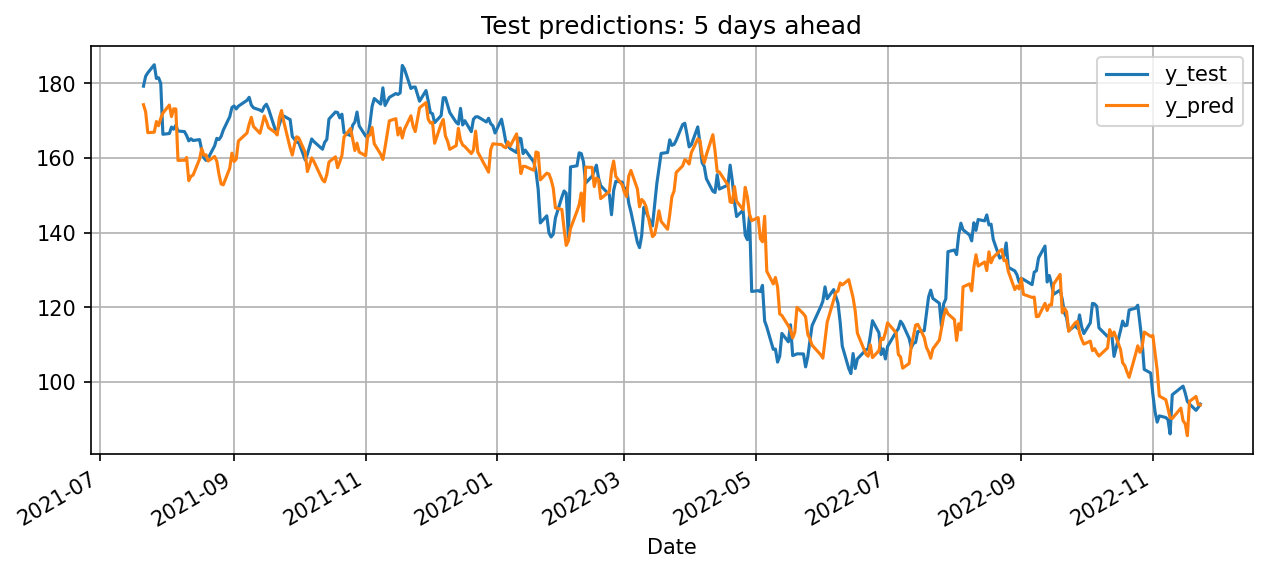

In [66]:
fig = plt.figure(figsize=(10,4), dpi=150)
df_2['y_test'].plot()
df_2['y_pred'].plot()
plt.legend(loc='best')
plt.title('Test predictions: %i days ahead'%M_future)
plt.grid(True)
plt.show()

In [67]:
mae = mean_absolute_error(df_2['y_test'], df_2['y_pred'])
mse = mean_squared_error(df_2['y_test'], df_2['y_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(df_2['y_test'], df_2['y_pred'])
print("MAE: %.2f " % (mae))
print("MSE: %.2f " % (mse))
print("RMSE: %.2f " % (rmse))
print("R-Squared: %.2f " % (r2))

MAE: 7.70 
MSE: 90.92 
RMSE: 9.54 
R-Squared: 0.87 


In [68]:
train = scaled_data[(test_split-M_future-N_past) % M_future : test_split]
test = scaled_data[test_split - N_past:]
print(train.shape)
print(test.shape)

(1925, 14)
(361, 14)


In [69]:
X_train, y_train = split_dataset_X_Y(train, N_past, M_future, M_future)
X_test, y_test = split_dataset_X_Y(test, N_past, M_future, M_future)

In [70]:
print('Last Close price for y_train is %.6f'%(y_train[-1][-1]))
print('First Close price for y_test is %.6f'%(y_test[0][0]))
print(test.iloc[N_past-1:N_past+1])

Last Close price for y_train is 0.985562
First Close price for y_test is 0.970907
                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2021-07-14  0.989840  0.984087  0.989463  0.985562   0.985562  0.105128   
2021-07-15  0.985605  0.977695  0.977769  0.970907   0.970907  0.100284   

                   k         d      macd       MOM       OBV  USD_index  \
Date                                                                      
2021-07-14  0.784107  0.828928  0.842876  0.785385  0.982037   0.379468   
2021-07-15  0.677059  0.757509  0.827649  0.734334  0.976804   0.385473   

            fed_fund_rate      gold  
Date                                 
2021-07-14       0.015831  0.755327  
2021-07-15       0.015831  0.755648  


In [71]:
train_predictions = model.predict(X_train).ravel()

12/12 [==============================] - 0s 3ms/step


In [72]:
test_predictions = model.predict(X_test).ravel()

3/3 [==============================] - 0s 4ms/step


In [73]:
y_true = np.concatenate((y_train.ravel(), y_test.ravel()), axis=0)

In [74]:
for _ in range(len(y_true)-len(train_predictions)):
  train_predictions = np.append(train_predictions, np.nan)
  
for _ in range(len(y_true)-len(test_predictions)):
  test_predictions = np.insert(test_predictions, 0, np.nan, axis=0)

In [75]:
assert (y_true.shape == train_predictions.shape == test_predictions.shape)

In [76]:
lb = (test_split-M_future-N_past) % M_future + N_past
ub = lb + len(y_true)

In [77]:
complete_df = pd.DataFrame({'y_true': sc_Y.inverse_transform(y_true.reshape(-1,1)).flatten(),
                            'train_predictions': sc_Y.inverse_transform(train_predictions.reshape(-1,1)).flatten(),
                            'test_predictions': sc_Y.inverse_transform(test_predictions.reshape(-1,1)).flatten()},
                           data[lb:ub].index)
complete_df

,y_true,train_predictions,test_predictions
Date,,,
2013-11-18,18.309000,19.202443,NaN
2013-11-19,18.247000,19.284258,NaN
2013-11-20,18.128500,19.219042,NaN
2013-11-21,18.445999,19.225612,NaN
2013-11-22,18.615499,19.145409,NaN
...,...,...,...
2022-11-16,97.120003,NaN,93.526443
2022-11-17,94.849998,NaN,93.599464
2022-11-18,94.139999,NaN,93.858177


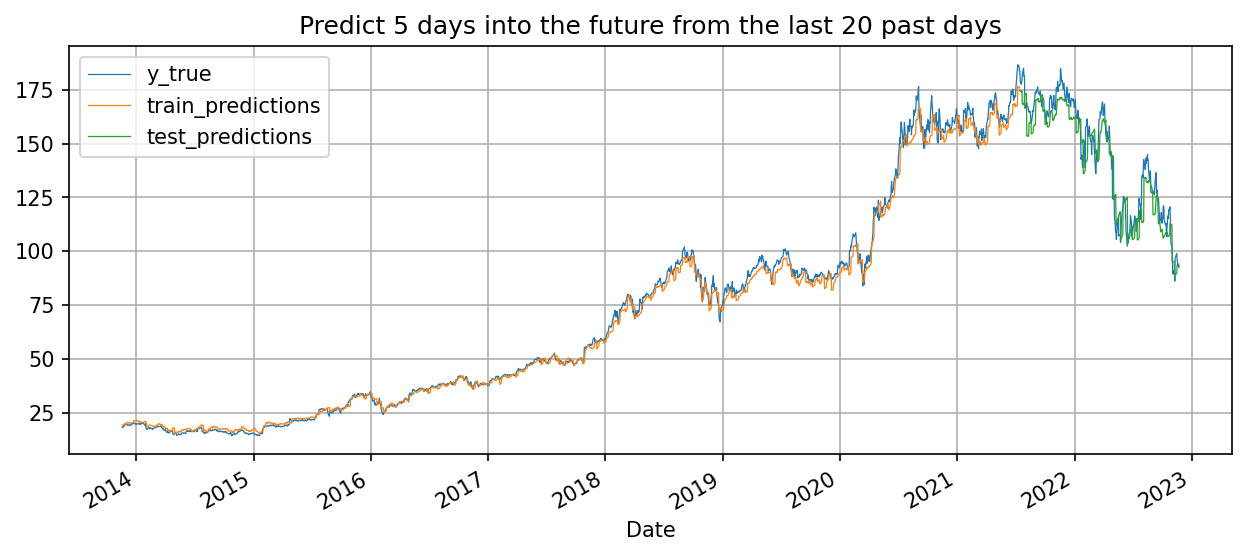

In [78]:
fig = plt.figure(figsize=(10,4), dpi=150)
complete_df['y_true'].plot(linewidth=0.6)
complete_df['train_predictions'].plot(linewidth=0.6)
complete_df['test_predictions'].plot(linewidth=0.6)
plt.legend(loc='best')
plt.title('Predict %i days into the future from the last %i past days'%(M_future,N_past))
plt.grid(True)
plt.show()

In [79]:
last_days = scaled_data[-N_past:].values.reshape(1, N_past, -1)

In [80]:
prediction = model.predict(last_days)
prediction = sc_Y.inverse_transform(prediction).flatten()

1/1 [==============================] - 0s 20ms/step


In [81]:
data[-1:]

,Open,High,Low,Close,Adj Close,Volume,k,d,macd,MOM,OBV,USD_index,fed_fund_rate,gold
Date,,,,,,,,,,,,,,
2022-11-23,93.239998,94.580002,92.830002,94.129997,94.129997,59414700,29.487265,35.45549,-4.483151,-21.530006,1.021720e+10,106.080002,3.83,163.080002


In [82]:
print('Predicted prices for the future %i days are:'%M_future)
for price in prediction:
  print(price)

Predicted prices for the future 5 days are:
89.956535
90.151924
90.469025
90.59609
90.980736


In [83]:
now = yf.download('AMZN', start = '2022-11-23', end = '2022-12-01')
aa = pd.DataFrame({'now': now['Adj Close'],
                   'prediction': prediction,
                  }, now.index)

[*********************100%***********************]  1 of 1 completed


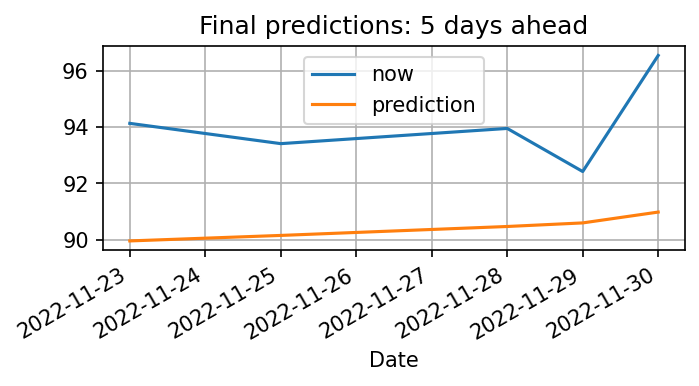

In [84]:
fig = plt.figure(figsize=(5,2), dpi=150)
aa['now'].plot()
aa['prediction'].plot()
plt.legend(loc='best')
plt.title('Final predictions: %i days ahead'%M_future)
plt.grid(True)
plt.show()

In [85]:
mae = mean_absolute_error(aa['now'], aa['prediction'])
mse = mean_squared_error(aa['now'], aa['prediction'])
rmse = np.sqrt(mse)
r2 = r2_score(aa['now'], aa['prediction'])
print("MAE: %.2f " % (mae))
print("MSE: %.2f " % (mse))
print("RMSE: %.2f " % (rmse))
print("R-Squared: %.2f " % (r2))

MAE: 3.66 
MSE: 14.88 
RMSE: 3.86 
R-Squared: -7.02 
